### Where are my trees?

This notebook runs through the method to identify AruCo markers in laser scans

<u>Prerequisites</u>
<ul>
<li>Compile and run <code><span style="background-color:lightgrey">mon2pcd</span></code>, this uses the mointoring point cloud to locate bright returns</li>
<li>Compile AruCo, this can be downloaded from <a href:https://sourceforge.net/projects/aruco/files/>here</a>. The code <code><span style="background-color:lightgrey">run.cpp</span></code> also needs to be compiled</li>
<li>Data needs to be tiled, annoyingly there needs to be 2 sets of tiles: one with reflectance values stored as an attribute and one with scan location stored as an attribute (working on a fix). In the meantime you need to compile and run <code><span style="background-color:lightgrey">rxp2pcd_refl</span></code> storing files in <code><span style="background-color:lightgrey">rxp2pcd_i</span></code> and <code><span style="background-color:lightgrey">rxp2pcd_loc</span></code> storing files in <code><span style="background-color:lightgrey">rxp2pcd_p</span></code></li>
<li>Downsample tiles in <code><span style="background-color:lightgrey">rxp2pcd_p</span></code> and store in <code><span style="background-color:lightgrey">downsample_p</span></code>. There is a python script to do this which also creates a tile index (see next point).</li>
<li>There needs to be a <code><span style="background-color:lightgrey">tile_index.dat</span></code> with the columns <i>tile : x : y</i>

In [1]:
%load_ext autoreload
%pylab
%matplotlib inline
import os
import glob
from subprocess import PIPE, Popen
import pandas as pd

from sklearn.cluster import DBSCAN

import ply_io
import pcd_io

other functions stored in relative path
from python.otherFunctions import *

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path += ['/home/ucfaptv/opt/qrdar/python/']

Make a directory called <code><span style="background-color:lightgrey">fiducial markers</span></code> navigate to it 

In [21]:
%%bash
cd /data/eos/TLS/australia/AEP-33/2018-08-24.001.riproject/extraction2delete/
mkdir fiducial_markers
mkdir clusters

mkdir: cannot create directory ‘fiducial_markers’: File exists


In [14]:
os.chdir('/data/eos/TLS/australia/AEP-33/2018-08-24.001.riproject/extraction2delete/fiducial_markers/')

### Use the monitoring point cloud to identify bright targets

First you need to compile <code><span style="background-color:lightgrey">mon2pcd.cpp</span></code> and run it: 

<code><span style="background-color:lightgrey">mon2pcd top_directory min_reflectance name_prefix</span></code>

This produces a single <code><span style="background-color:lightgrey">.pcd</span></code> which can be read in below.

<code><span style="background-color:lightgrey">mon2pcd.cpp</span></code> has the same dependencies as <i>treeseg</i>

In [15]:
# read in points and filter
pc = pcd_io.read_pcd('../aep33_mon.pcd')
pc = pc[pc.intensity >= 0]

# voxelise for easy clustering 
W = 50
pc.loc[:, 'xx'] = (pc.x // W) * W
pc.loc[:, 'yy'] = (pc.y // W) * W

### Identifying reflective points
Run <b>dbscan</b> to find potential clusters of points. This is done over gridded data so as to avoid memory errors.

In [16]:
label_max = 0
target_centre = pd.DataFrame()

for tx, ty in pc.groupby(['xx', 'yy']).size().index:
        
    sq = pc[(pc.xx == tx) & (pc.yy == ty)]
    print 'processing grid {} {} with length {}'.format(tx, ty, len(sq))
    
    if len(sq) >= 5: # if tiles contain too few points, skip them        
        dbscan = DBSCAN(eps=.025, min_samples=5).fit(sq[['x', 'y', 'z']])
        pc.loc[sq.index, 'sticker_labels_'] = dbscan.labels_ + label_max
        label_max = pc.sticker_labels_.max() + 1 # iterative labelling hence 
    
    else: 
        pc.loc[sq.index, 'sticker_labels_'] = -1
        
pc = pc[pc.sticker_labels_ != -1] # remove outlier points
        
# points can be coloured by cluster for visualisation
RGB = pd.DataFrame({l:np.random.randint(0, high=255, size=3) for l in pc.sticker_labels_.unique()}).T
RGB.columns = ['red', 'green', 'blue']
pc = pd.merge(pc, RGB, left_on=pc.sticker_labels_, right_on=RGB.index.values, how='outer')

# save points to .ply
ply_io.write_ply('potential_points.ply', pc)

processing grid -150.0 0.0 with length 3
processing grid -100.0 -50.0 with length 24201
processing grid -100.0 0.0 with length 257015
processing grid -100.0 50.0 with length 1
processing grid -50.0 -50.0 with length 133603
processing grid -50.0 0.0 with length 703563
processing grid -50.0 50.0 with length 1
processing grid 0.0 -50.0 with length 2
processing grid 0.0 0.0 with length 5600


Once this has been performed once it is easier to save the file and read in again

In [17]:
pc = ply_io.read_ply('potential_points.ply')

### Identify stickers
Next potential clusters are filtered by size and then groouped into potential tree codes

In [42]:
# group points in to potential stickets and estimate size and locations
potential_dots = pc.groupby('sticker_labels_').agg({'x':(ptp, mean), 'y':(ptp, mean), 'z':(ptp, mean)})
potential_dots.columns = ['y_ptp', 'y', 'x_ptp', 'x', 'z_ptp', 'z']
potential_dots.reset_index(inplace=True)
N = len(potential_dots)

# filter by size
func = lambda row: np.max([row['x_ptp'], row['y_ptp'], row['z_ptp']])
potential_dots.loc[:, 'max_ptp'] = potential_dots.apply(func, axis=1)
potential_dots = potential_dots[potential_dots.max_ptp < .05]

print 'number of potential stickers:', len(potential_dots)
print '(removed by size):', N - len(potential_dots)

number of potential stickers: 118
(removed by size): 413


### Identify targets

In [43]:
# target_centre = pc.loc[pc.labels_.isin(potential_dots.index)].groupby('labels_').mean()
dbscan = DBSCAN(eps=.4, min_samples=3).fit(potential_dots[['x', 'y', 'z']])
potential_dots.loc[:, 'target_labels_'] = dbscan.labels_
potential_dots = potential_dots[potential_dots.target_labels_ != -1]

# find code centres
code_centre = potential_dots.groupby('target_labels_')[['x', 'y', 'z']].mean().reset_index()
print 'number of potential targets:', len(code_centre)

number of potential targets: 12


In [27]:
# filters points that are not correctly spaced
# finds the centre of dots
target_centre = pc.loc[pc.sticker_labels_.isin(potential_dots.index)].groupby('sticker_labels_').mean()

nbrs = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(target_centre[['x', 'y', 'z']].values)
distances, indices = nbrs.kneighbors(target_centre[['x', 'y', 'z']].values)

targets = {}
targets_all = set()
i = 0

# loop over dots and cluster them according to location
for distance, ix in zip(distances, indices):

    ix = target_centre.index[ix].values.astype(int)
    mask = distance < .4 # remove outliers
    
    if np.any(mask[1:]):

        ix = ix[np.where(mask)]

        found = False
        targets_all = targets_all.union(ix)
        
        # creates sets of suitably spaced points
        for k, v in targets.items():
            if len(set(ix).intersection(v)) > 0:
                targets[k] = targets[k].union(ix)
                found = True
                break
        if not found: 
            targets[i] = set(ix)
            i += 1

# filters if not enough points
targets = [v for v in targets.values() if len(v) > 2] 
print 'number of potential targets:', len(targets)

number of potential targets: 48


### Read AruCo codes

In [44]:
# create a database to store output metadata
marker_df = pd.DataFrame(index=np.arange(len(code_centre)),
                         columns=['x', 'y', 'z', 'rmse', 'aruco'])
marker_df.loc[:, 'extract'] = False
marker_df.loc[:, 'dup'] = False

and run........

this can take anything between a few seconds and many minutes per marker depending on the number of potential dots found for each target.

processing targets: 0
    identifying stickers
    RMSE: 0.00760499026823
    applying rotation matrix
    extracting fiducial marker
    running method 1
    running method 2
    saving images: 0.png
    reading targets with ARuCO
    tag identified: 107
        processing tile: 59
        processing tile: 60
        processing tile: 70
        processing tile: 71
    running DBSCAN on voxel
    saving stem: ../clusters/cluster_107.pcd
processing targets: 1
    identifying stickers
    RMSE: 0.00600732287738
    applying rotation matrix
    extracting fiducial marker
    running method 1
    running method 2
    saving images: 1.png
    reading targets with ARuCO
    tag identified: 108
        processing tile: 27
        processing tile: 28
        processing tile: 38
        processing tile: 39
    running DBSCAN on voxel
    saving stem: ../clusters/cluster_108.pcd
processing targets: 2
    identifying stickers
    RMSE: 0.00713338768357
    applying rotation matrix
    extracting 

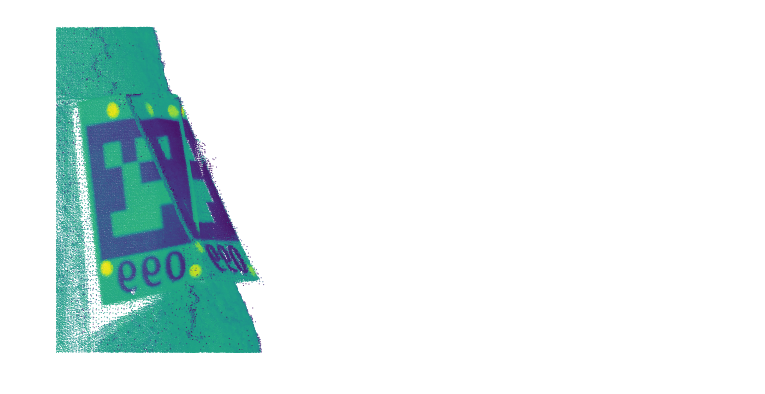

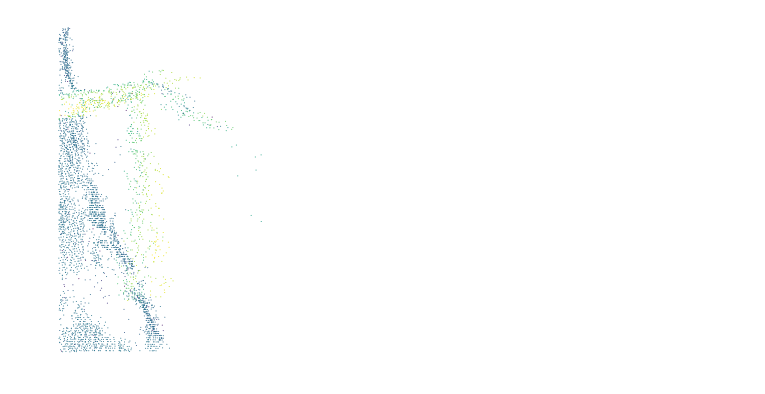

In [77]:
%autoreload 2
from otherFunctions import *

tile_centres = pd.read_csv('../tile_index.dat',
                           names=['tile', 'x', 'y'], sep=' ')

template = np.array([[ 0.      ,  0, 0.      ],
                     [ 0.182118,  0, 0.0381  ],
                     [ 0.      ,  0, 0.266446],
                     [ 0.131318,  0, 0.266446]])
template = pd.DataFrame(data=template, columns=['x', 'y', 'z'])

version = 'x'
prefix = 'aep33'
min_intesity = 0

for i in code_centre.target_labels_.unique():
    
#     if i != 5: continue
    
    print 'processing targets:', i
        
    # locate and extract tile
    corners = potential_dots[potential_dots.target_labels_ == i]
    code, tile_names = extract_tile(corners, marker_df, i, tile_centres, prefix)
    
    code = code.append(pc[(pc.x.between(corners.x.min(), corners.x.max())) &
                      (pc.y.between(corners.y.min(), corners.y.max())) &
                      (pc.z.between(corners.z.min(), corners.z.max())) &
                      (pc.intensity > 0)][['x', 'y', 'z', 'intensity']])
    
    # create axis for plotting
    f = plt.figure(figsize=(10, 5))
    ax1 = f.add_axes([0, 0, .32, 1])
    ax2 = f.add_axes([.33, .5, .32, .49])
    ax3 = f.add_axes([.33, 0, .32, .49])
    ax4 = f.add_axes([.66, 0, .32, .49])
    ax5 = f.add_axes([.66, .5, .32, .49])
    [ax.axis('off') for ax in [ax1, ax2, ax3, ax4, ax5]]
    
    # identify stickers
    print '    identifying stickers'
    stickers, intensity, all_R, all_rmse, all_sticker_centres, combinations = identify_stickers(code, template, min_intesity=min_intesity)
    if intensity == min_intesity or marker_df.extract.loc[i]:
        print "    aborting: could not find 3 bright targets taht match the template"
        code.sort_values('y', inplace=True)
        ax1.scatter(code.x, code.z, c=code.intensity, edgecolor='none', s=1)
        f.savefig('{}.png'.format(i))
        if marker_df.extract.loc[i]:
            print '    attempting to locate stem anyway'
            extract_voxel(corners, 'u' + str(i), tile_centres)
            code[['x', 'y', 'z', 'intensity']].to_csv('../clusters/code_u{}.txt'.format(i), index=False)
            plt.clf()
        continue

    ix = np.where(all_rmse == np.array(all_rmse).min())[0][0]
    R = all_R[ix]
    RMSE = all_rmse[ix]
    marker_df.loc[i, 'rmse'] = RMSE
    print '    RMSE:', RMSE

    idx = combinations[ix]
    sticker_centres = all_sticker_centres.loc[list(idx)]

    # applying rotation matrix
    print '    applying rotation matrix'
    sticker_centres.loc[:, ['x', 'y', 'z']] = apply_rotation(R, sticker_centres)
    code.loc[:, ['x', 'y', 'z']] = apply_rotation(R, code)

    # set up and plot point cloud
    code.sort_values('y', inplace=True, ascending=False)
    ax1.scatter(code.x, code.z, c=code.intensity, edgecolor='none', s=1, cmap=plt.cm.Spectral_r)
    ax1.scatter(template.x, template.z, s=30, edgecolor='b', facecolor='none')
    ax1.scatter(sticker_centres.x, sticker_centres.z, s=30, edgecolor='r', facecolor='none')

    # extracting fiducial marker
    print '    extracting fiducial marker'
    code_ = code.copy()
    code = code.loc[(code.x.between(-.01, .18)) & 
                    (code.y.between(-.01, .01)) &
                    (code.z.between(.06, .25))]
    code.x = code.x - code.x.min()
    code.z = code.z - code.z.min()
    code.loc[:, 'xx'] = code.x // 0.032
    code.loc[:, 'zz'] = code.z // 0.032

    # correct for non-flat target
#     code.loc[:, 'yt'] = code.groupby(['xx', 'zz']).y.transform(np.percentile, 75)
#     code.loc[:, 'yn'] = code.y - code.yt
#     code = code.loc[code.yn.between(-.01, .01)]

    code.sort_values('intensity', inplace=True)
    ax2.scatter(code.x, code.z, c=code.intensity, edgecolor='none', s=10, cmap=plt.cm.Greys_r, vmin=-10, vmax=-5)

    # method 1
    try:
        img_1 = method_1(code)
        ax3.imshow(np.rot90(img_1, 1), cmap=plt.cm.Greys_r, interpolation='none')

    except Exception as err:
        print err
        pass

    # method 2
    try:
        print '    running method 2'
        code.loc[:, 'N'] = code.groupby(['xx', 'zz']).x.transform(size)
        LN = code[(code.intensity < -7) ].groupby(['xx', 'zz']).x.size().reset_index(name='LN')
        code = pd.merge(LN, code, on=['xx', 'zz'], how='outer')
        code.loc[:, 'P'] = code.LN / code.N

        for ax, threshold in zip([ax4, ax5], [.4, .6]):

            code.loc[:, 'bw_2'] = code.P.apply(lambda p: 0 if p > threshold else 1)
            img_2 = code.groupby(['xx', 'zz']).bw_2.mean().values.reshape(6, 6)
            img_2 = img_2 * np.pad(np.ones(np.array(img_2.shape) - 2), 1, 'constant') # force border to be black
            ax.imshow(np.rot90(img_2, 1), cmap=plt.cm.Greys_r, interpolation='none')
            ax.axis('off')

    except Exception as err:
        print err
        pass

    print '    saving images:', '{}.png'.format(i)
    f.savefig('{}.png'.format(i))
    plt.clf()

    print '    reading targets with ARuCO'
    N = Popen(['/home/ucfaptv/opt/aruco-3.0.7/mine/read', 
               '{}.png'.format(i)],
                stdout=PIPE)

    codeN = N.stdout.readline().strip()
    if len(codeN) > 0:
        print '    tag identified:', codeN
    else:
        print '    !no code identified, continuing anyway!'
        code_[['x', 'y', 'z']] = apply_rotation(np.linalg.inv(R), code_)
        code_[['x', 'y', 'z', 'intensity']].to_csv('../clusters/code_u{}.txt'.format(i), index=False)
        codeN = 'u' + str(i)
        
    marker_df.loc[i, 'aruco'] = codeN
    voxel, sc = extract_voxel(corners, codeN, tile_centres, prefix, sticker_centres=sticker_centres, R=R)
    marker_df.to_csv('marker_df.csv')

#     break
#     if i > 10: break
                                                 

In [75]:
print marker_df

          x        y           z        rmse aruco  extract    dup
0  -60.1078  17.1081     1.19046  0.00671085   107    False  False
1  -83.5302  32.5279     2.59872  0.00563188   108    False  False
2  -25.5795 -1.60406     0.25736  0.00633332    98    False  False
3  -4.98987  8.94421    0.367727  0.00576853   100    False  False
4  -1.87042  18.8404    0.368373  0.00611991    u4    False  False
5  -15.1033  20.0124    0.409991  0.00633857    u5    False  False
6  -13.5435  14.0942   -0.332881         NaN   NaN    False  False
7  -4.92632  26.2521     0.22696  0.00542782    u7    False  False
8  -3.45389   26.041 -0.00130548         NaN   NaN    False  False
9  -2.45496  37.2316    0.446711  0.00564644    94    False  False
10 -45.0848  39.5277    0.929968   0.0041061   u10    False  False
11 -44.1378  43.8623     1.44671  0.00716716   104    False  False
